In [2]:
%%capture
!pip install statsforecast

In [52]:
##########
import os
import pandas as pd
import numpy as np
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from scipy.stats import norm
from statsforecast import StatsForecast
from statsforecast.models import (
    HoltWinters,
    CrostonClassic as Croston,
    HistoricAverage,
    DynamicOptimizedTheta as DOT,
    SeasonalNaive,
    AutoARIMA
)
from utilsforecast.losses import mse
from utilsforecast.evaluation import evaluate

# Set environment variable
os.environ['NIXTLA_ID_AS_COL'] = '1'

##########
# Read the data
df = pd.read_csv("https://raw.githubusercontent.com/TRiS65/NYUBootcamp/main/Metro_Interstate_Traffic_Volume.csv", delimiter=",")

df_nixtla = pd.read_parquet('https://datasets-nixtla.s3.amazonaws.com/m4-hourly.parquet')

In [16]:
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,NaN,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,NaN,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,NaN,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,NaN,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,NaN,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [9]:
df_nixtla.head()

,unique_id,ds,y
0,H1,1,605.0
1,H1,2,586.0
2,H1,3,586.0
3,H1,4,559.0
4,H1,5,511.0


In [12]:
df.dtypes

,0
holiday,object
temp,float64
rain_1h,float64
snow_1h,float64
clouds_all,int64
weather_main,object
weather_description,object
date_time,object
traffic_volume,int64


In [53]:
df = df.drop(columns = ['holiday','weather_main','weather_description'])

In [58]:
df = df.rename(columns={'date_time':'ds'})

In [60]:
df_melt = pd.melt(df, id_vars=['ds'],value_vars=['temp','rain_1h','snow_1h','clouds_all','traffic_volume'], var_name='unique_id', value_name='y')

In [61]:
df_melt

,ds,unique_id,y
0,2012-10-02 09:00:00,temp,288.28
1,2012-10-02 10:00:00,temp,289.36
2,2012-10-02 11:00:00,temp,289.58
3,2012-10-02 12:00:00,temp,290.13
4,2012-10-02 13:00:00,temp,291.14
...,...,...,...
241015,2018-09-30 19:00:00,traffic_volume,3543.00
241016,2018-09-30 20:00:00,traffic_volume,2781.00
241017,2018-09-30 21:00:00,traffic_volume,2159.00
241018,2018-09-30 22:00:00,traffic_volume,1450.00


In [62]:
Y_df = df_melt.copy()

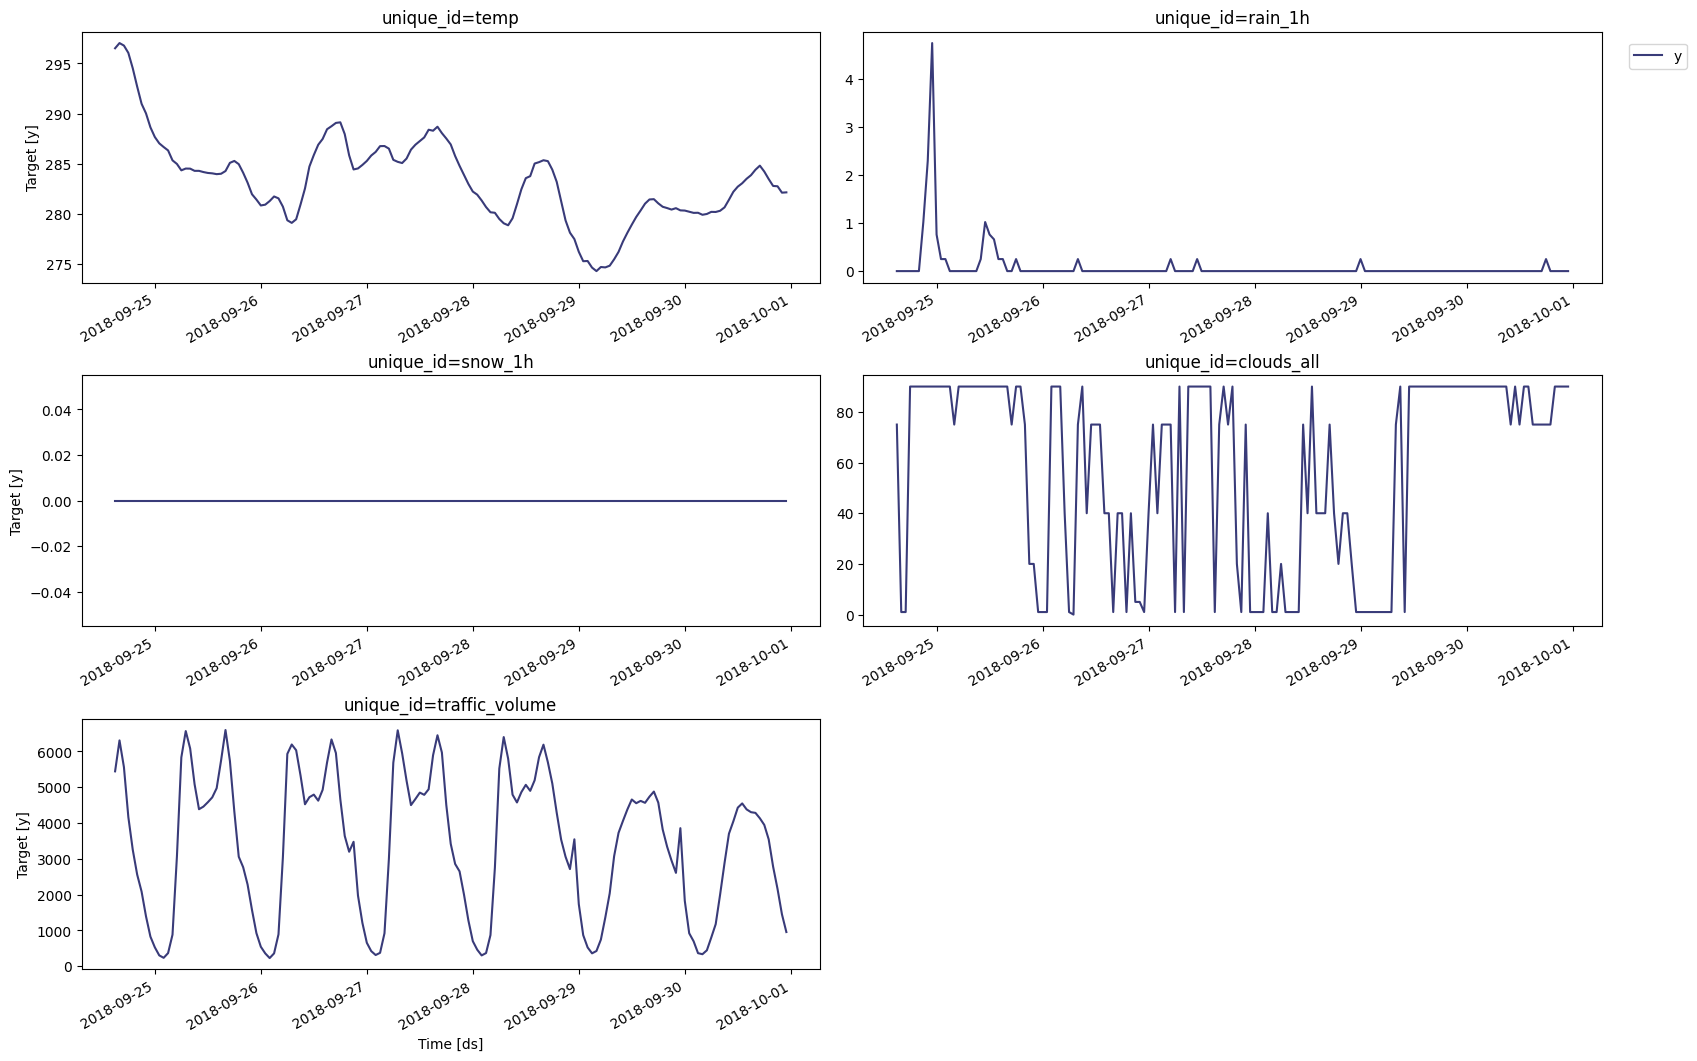

In [63]:
# Select subset of data
uids = Y_df['unique_id'].unique()[:10]
Y_df = Y_df.query('unique_id in @uids')
Y_df = Y_df.groupby('unique_id').tail(7 * 24)

##########
# Explore data
StatsForecast.plot(Y_df)



1. HoltWinters: Triple exponential smoothing, good for data with both trend and seasonality.
1. Croston: Designed for intermittent demand forecasting.
1. SeasonalNaive(season_length=24): Uses the value from the same time in the previous season. The season_length=24 suggests hourly data with daily seasonality.
1. HistoricAverage: Uses the mean of all historical data points.
1. DOT (Dynamic Optimized Theta): A variant of the Theta method, good for data with seasonality.

In [67]:
##########
# Define models
models = [
    HoltWinters(),
    Croston(),
    SeasonalNaive(season_length=24),
    HistoricAverage(),
    DOT(season_length=24),
    # AutoARIMA(season_length=24) ## slightly slow ignoring for now
]

#The season_length=24 refers to hourly data with daily seasonality.

# Instantiate StatsForecast
sf = StatsForecast(
    models=models,
    # freq=1,
    freq='H', # have to add ## freq='D', because dealing with real dates
    fallback_model = SeasonalNaive(season_length=3), ## if other models fail
    n_jobs=-1,
)



* df=Y_df: The input data frame.
* h=48: Forecast horizon of 48 time units (likely 48 hours).
* level=[90]: Generates 90% prediction intervals.

In [68]:
# Generate forecasts
forecasts_df = sf.forecast(df=Y_df, h=48, level=[90])

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:693: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


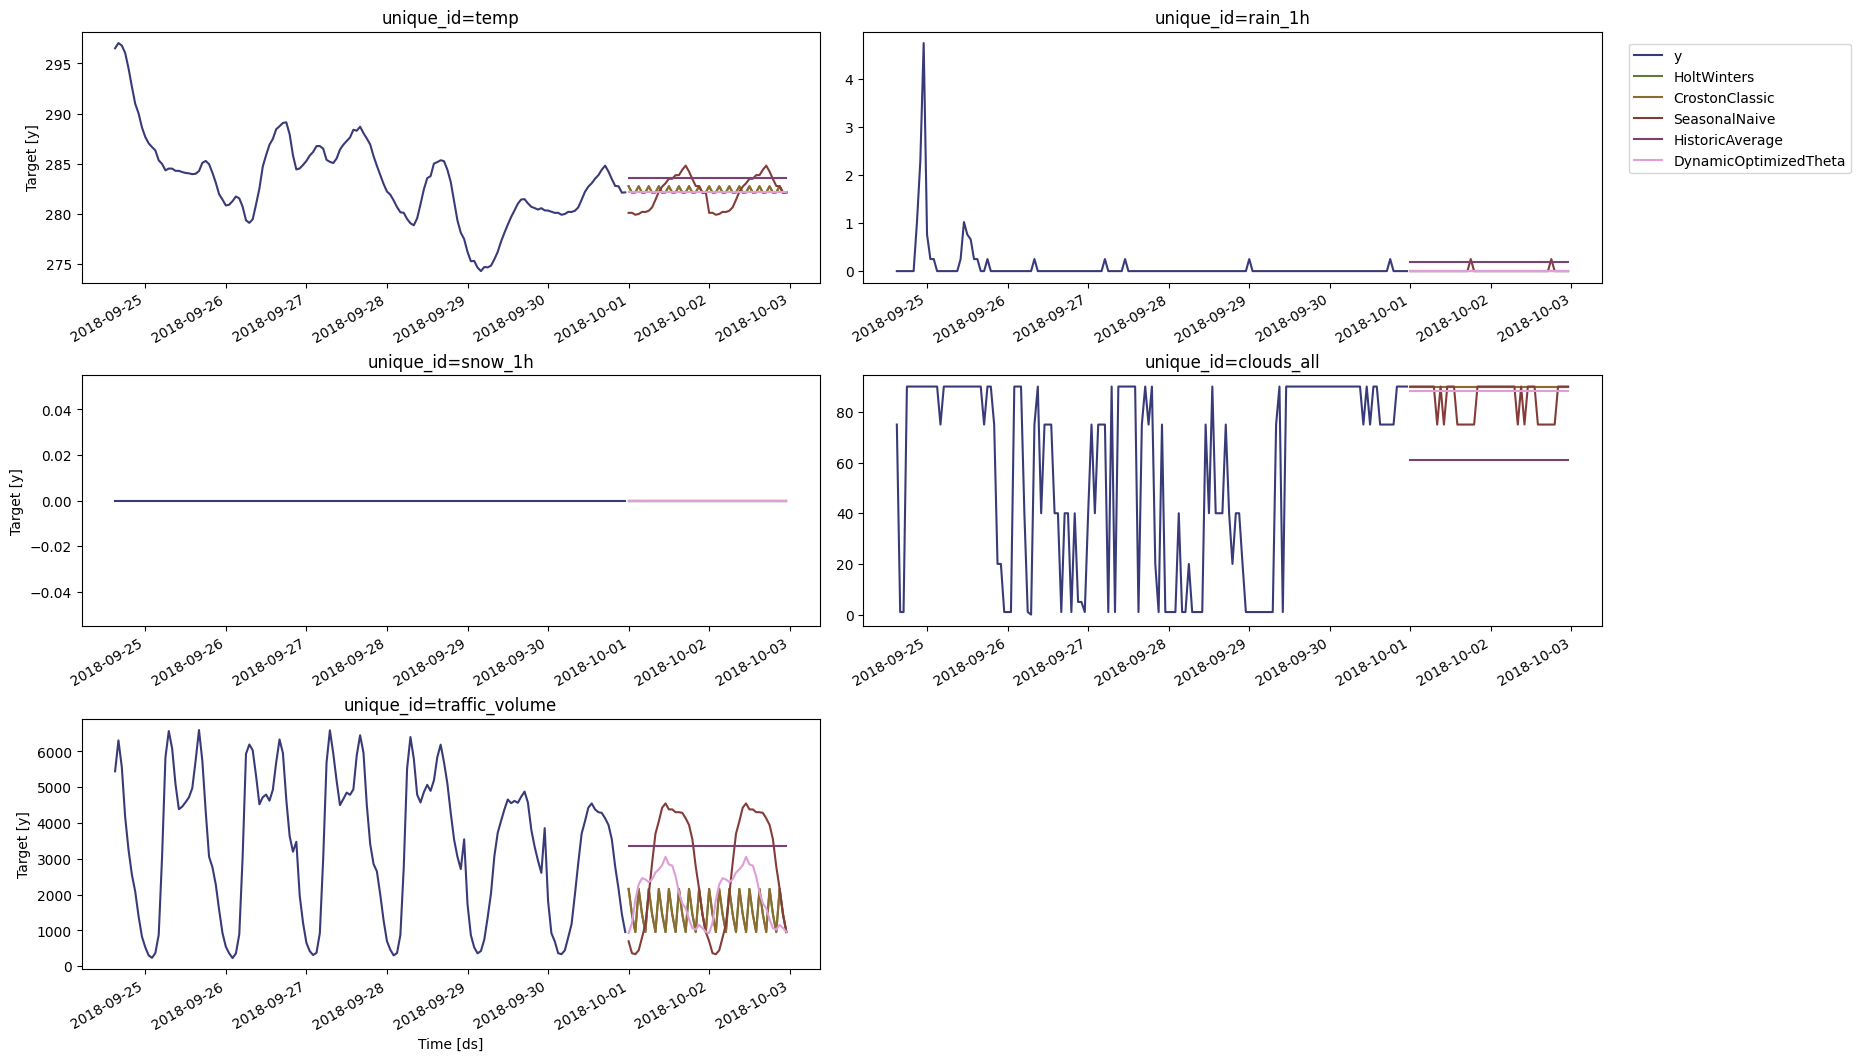

In [69]:
##########
# Plot forecasts
sf.plot(Y_df, forecasts_df)

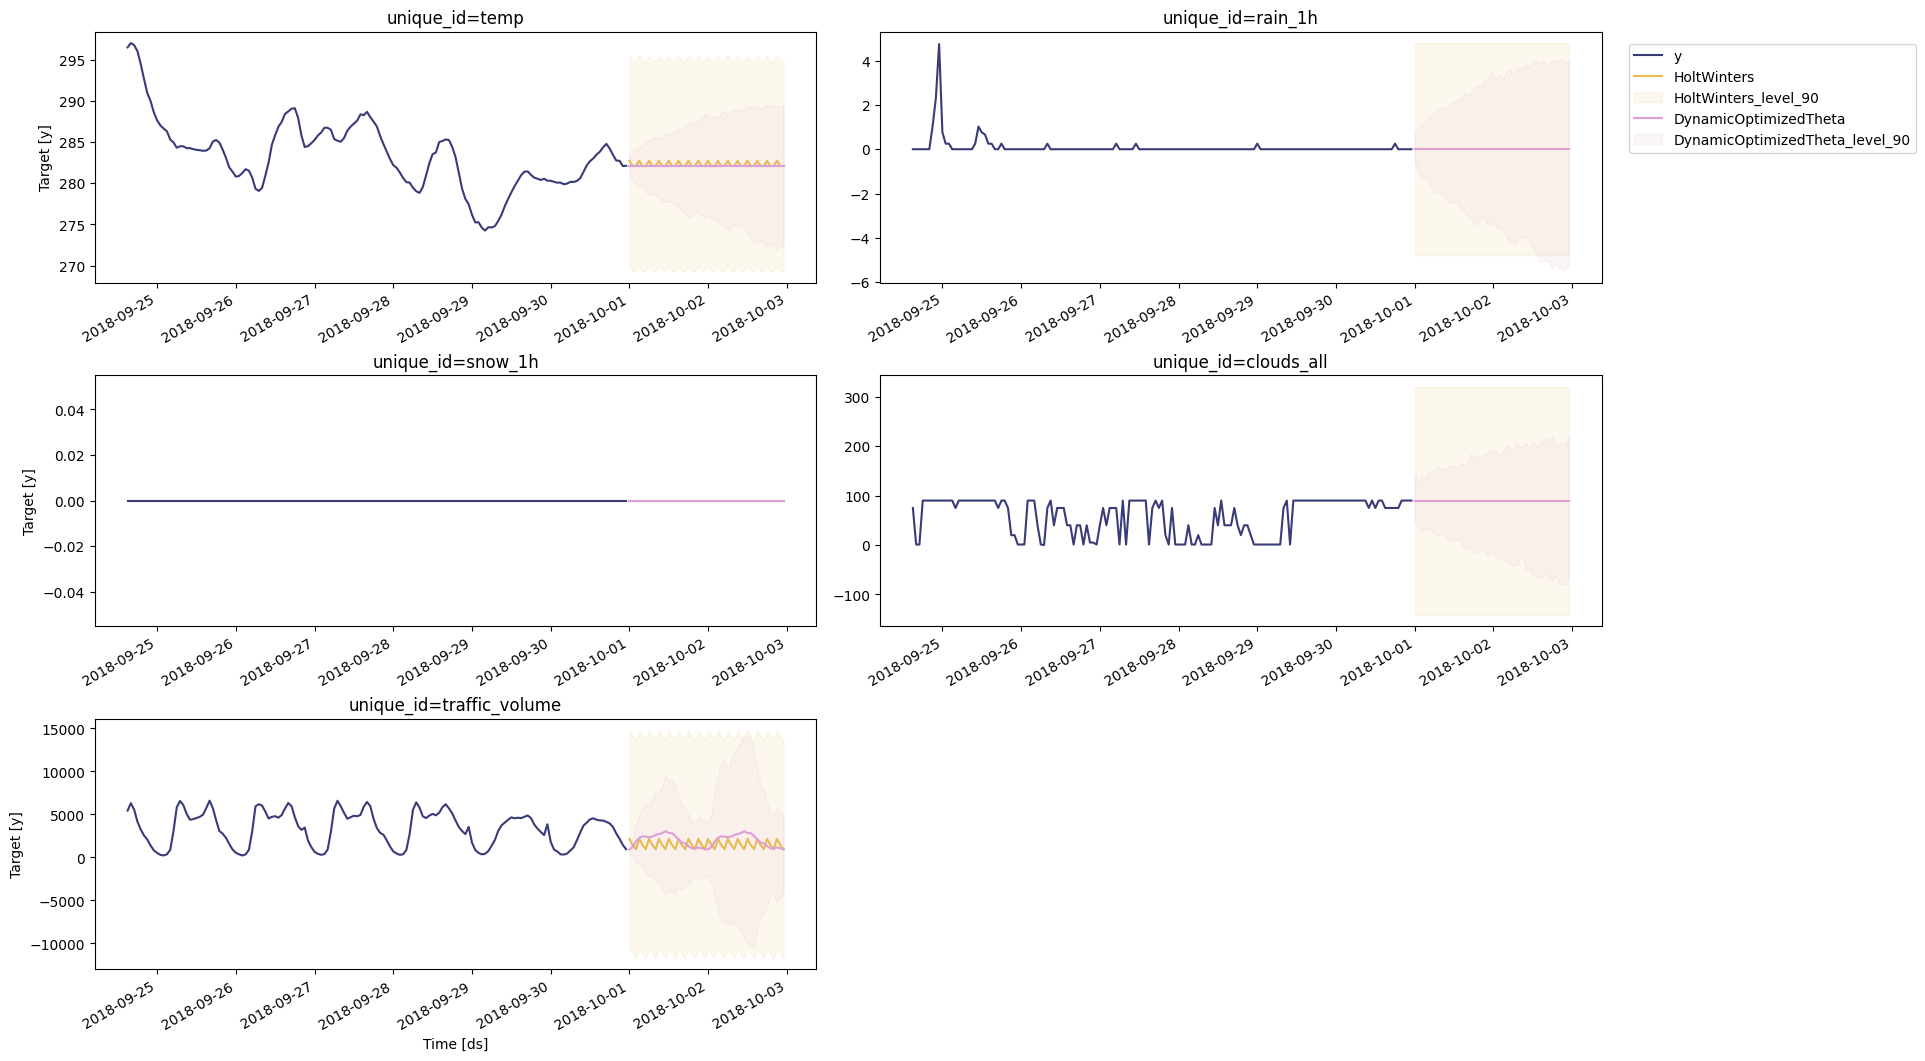

In [73]:
sf.plot(Y_df, forecasts_df, models=["HoltWinters","DynamicOptimizedTheta"], unique_ids=['temp','rain_1h','snow_1h','clouds_all','traffic_volume'], level=[90])


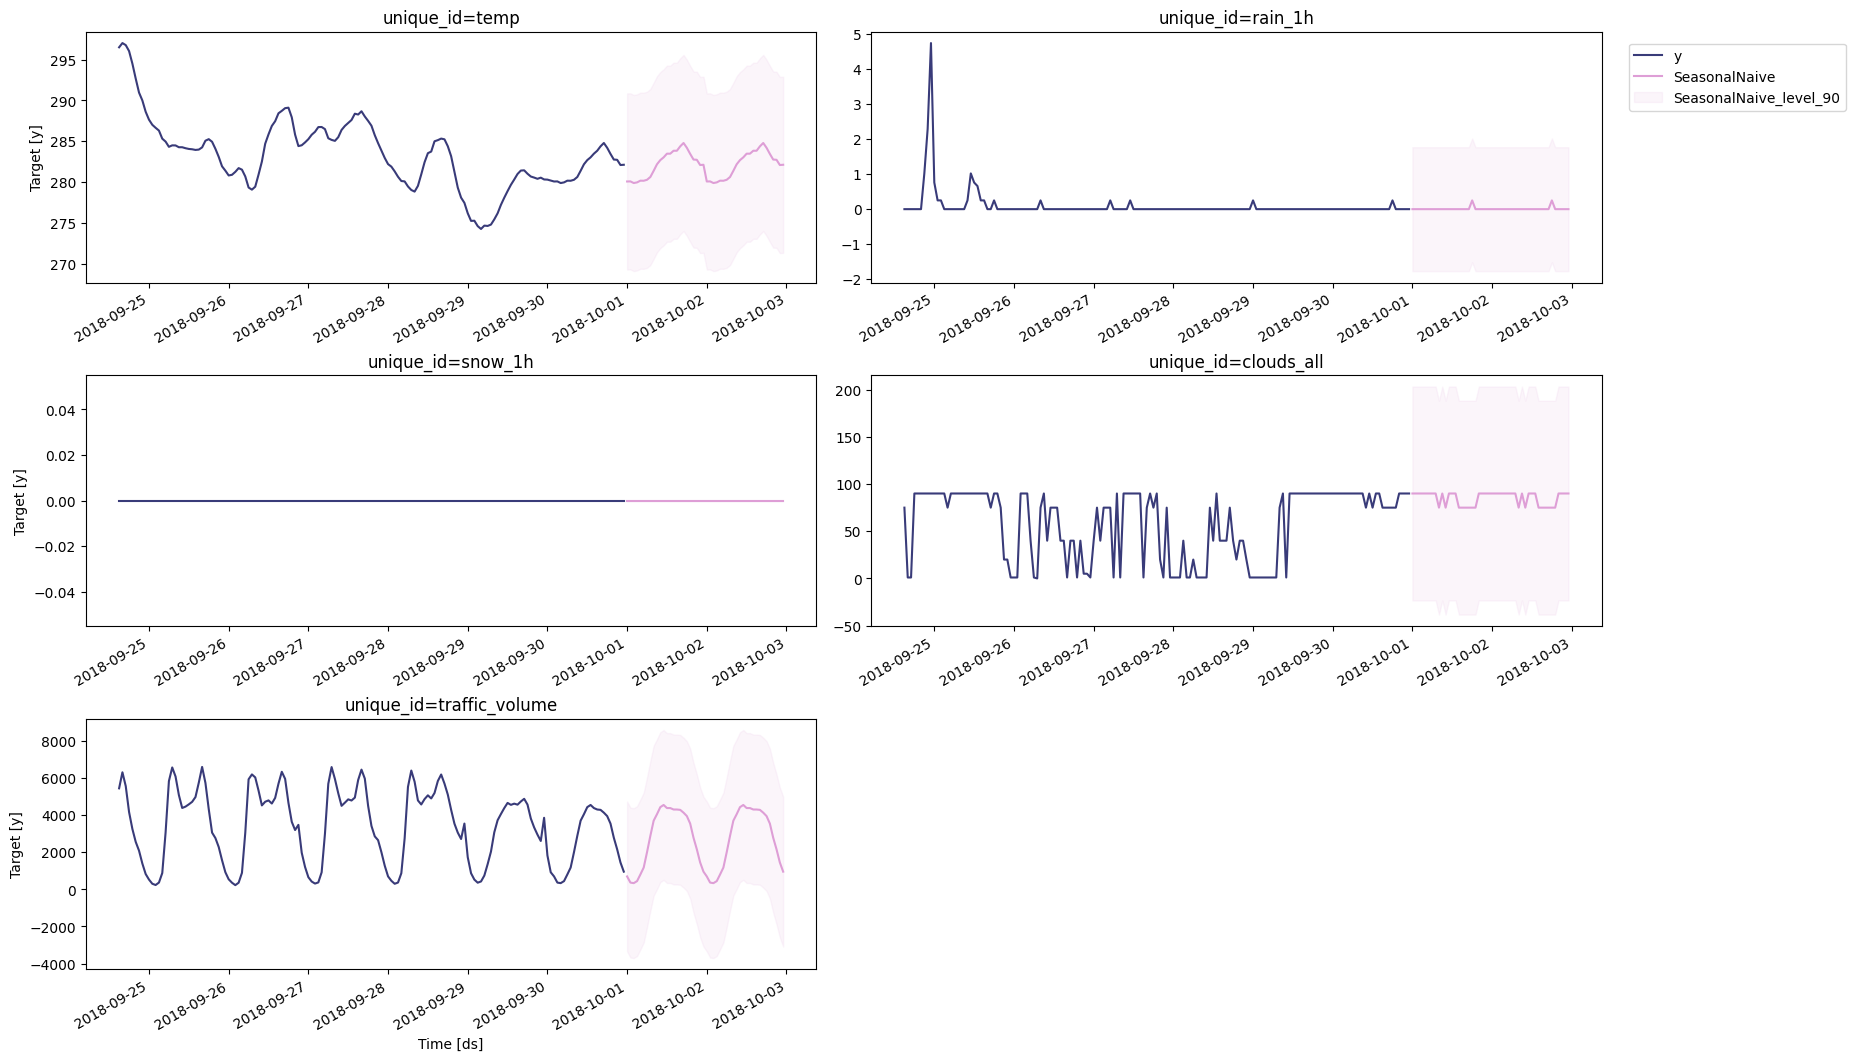

In [74]:
sf.plot(Y_df, forecasts_df, models=["SeasonalNaive"], unique_ids=['temp','rain_1h','snow_1h','clouds_all','traffic_volume'], level=[90])

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:693: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


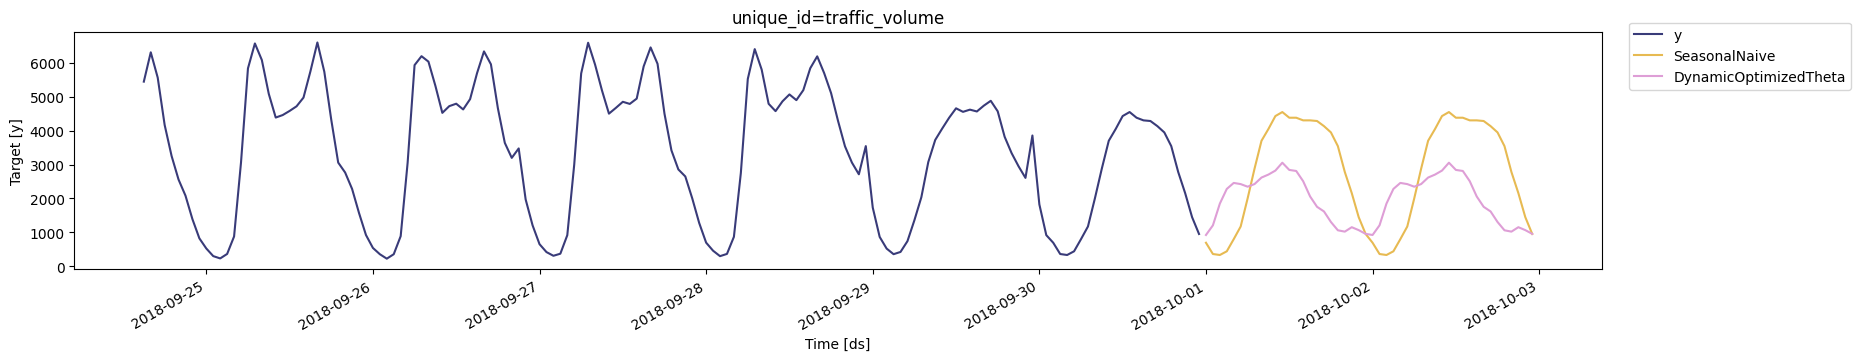

In [75]:
##########
# Cross-validation
crossvaldation_df = sf.cross_validation(
    df=Y_df,
    h=24,
    step_size=24,
    n_windows=2
)

##########
# Evaluation function
def evaluate_cross_validation(df, metric):
    models = df.drop(columns=['unique_id', 'ds', 'cutoff', 'y']).columns.tolist()
    evals = []
    for cutoff in df['cutoff'].unique():
        eval_ = evaluate(df[df['cutoff'] == cutoff], metrics=[metric], models=models)
        evals.append(eval_)
    evals = pd.concat(evals)
    evals = evals.groupby('unique_id').mean(numeric_only=True)
    evals['best_model'] = evals.idxmin(axis=1)
    return evals

# Evaluate models
evaluation_df = evaluate_cross_validation(crossvaldation_df, mse)

# Create summary
summary_df = evaluation_df.groupby('best_model').size().sort_values().to_frame()
summary_df.reset_index().columns = ["Model", "Nr. of unique_ids"]

# Plot best model for specific IDs
seasonal_ids = evaluation_df.query('best_model == "SeasonalNaive"').index
sf.plot(Y_df, forecasts_df, unique_ids=seasonal_ids, models=["SeasonalNaive","DynamicOptimizedTheta"])

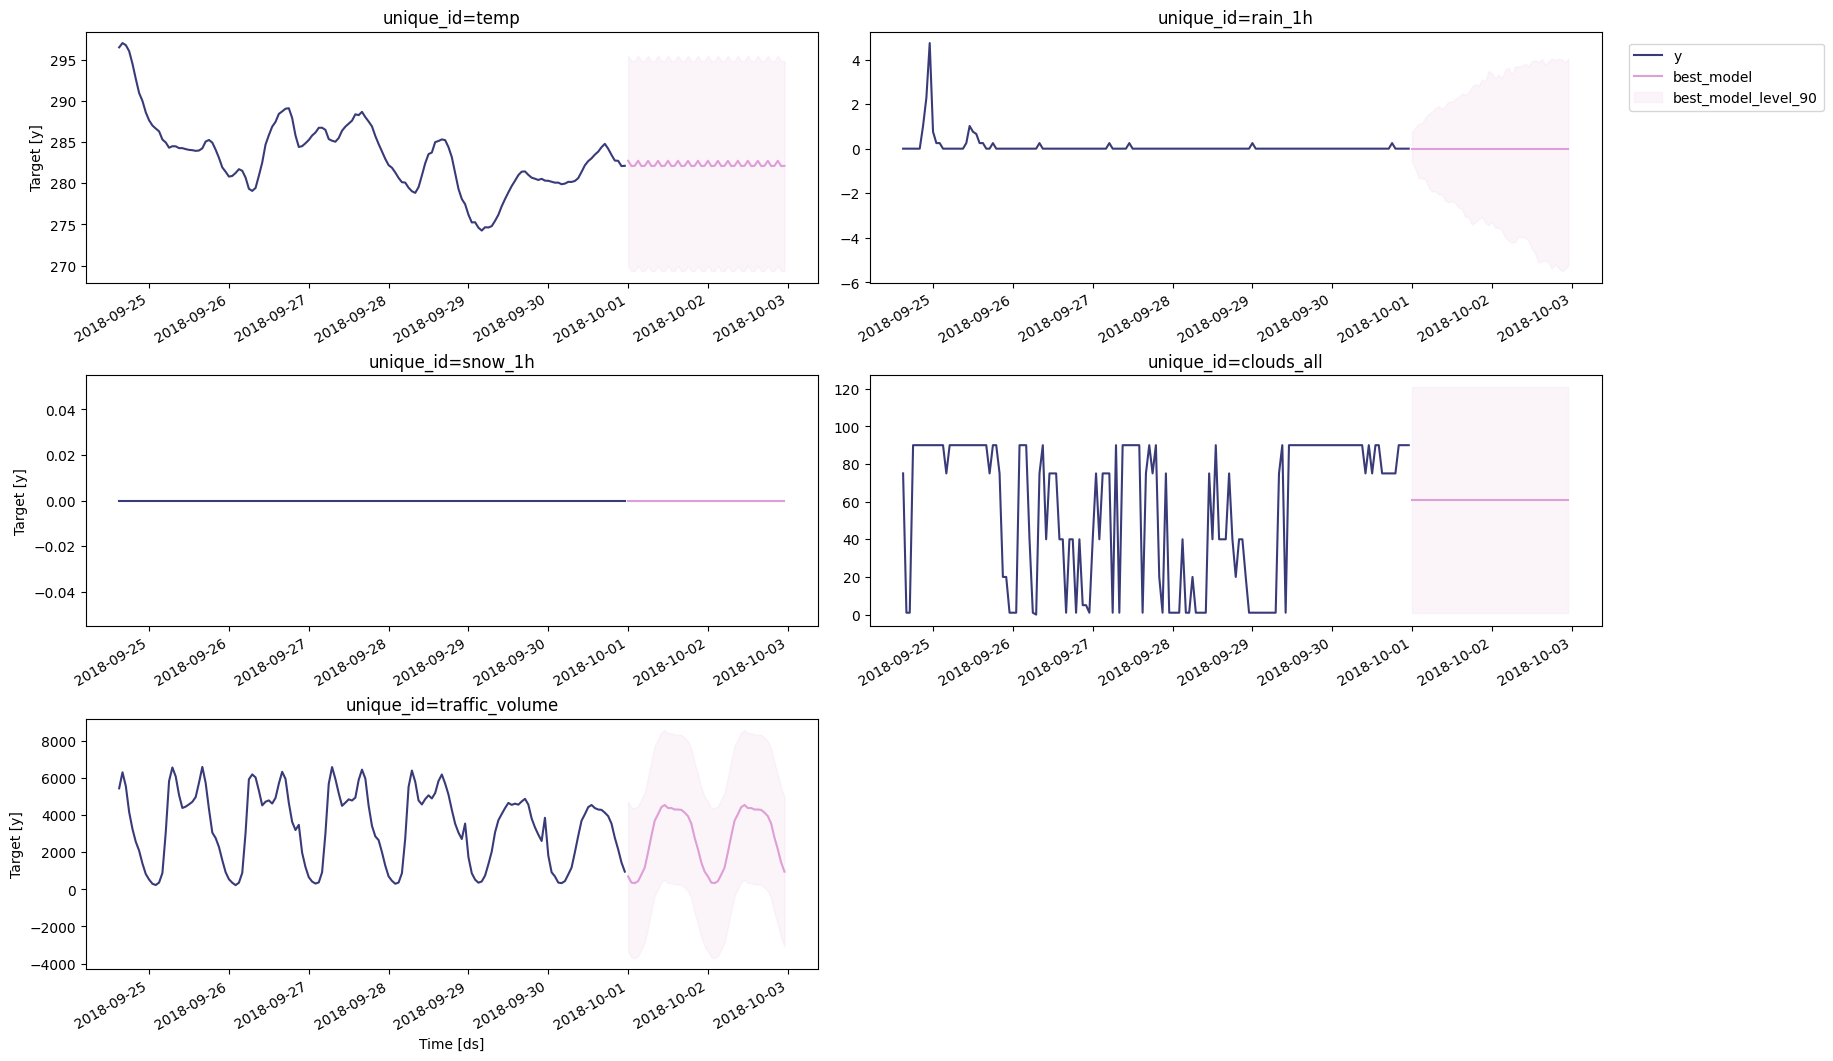

In [76]:
##########
# Select best model for each series
def get_best_model_forecast(forecasts_df, evaluation_df):
    df = forecasts_df.set_index(['unique_id', 'ds']).stack().to_frame().reset_index(level=2)
    df.columns = ['model', 'best_model_forecast']
    df = df.join(evaluation_df[['best_model']])
    df = df.query('model.str.replace("-lo-90|-hi-90", "", regex=True) == best_model').copy()
    df.loc[:, 'model'] = [model.replace(bm, 'best_model') for model, bm in zip(df['model'], df['best_model'])]
    df = df.drop(columns='best_model').set_index('model', append=True).unstack()
    df.columns = df.columns.droplevel()
    df.columns.name = None
    df = df.reset_index()
    return df

# Get best model forecasts
prod_forecasts_df = get_best_model_forecast(forecasts_df, evaluation_df)

# Plot final results
sf.plot(Y_df, prod_forecasts_df, level=[90])

##########